# Manifold GP Semi-Supervised Learning via Precision Matrix on 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

from manifold_gp.priors.inverse_gamma_prior import InverseGammaPrior
from gpytorch.priors import NormalPrior, GammaPrior

## Dataset Preprocessing

### Load

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

num_train = 10
num_test = 1000
normalize_features = False
normalize_labels = True

### Noise Features

In [3]:
noise_sampled_x = 0.0
noisy_x = sampled_x + noise_sampled_x * torch.randn(m, n)

### Trainset & Testset

In [4]:
torch.manual_seed(1337)
rand_idx = torch.randperm(m)
train_idx = rand_idx[:num_train]
train_x, train_y = noisy_x[train_idx, :], sampled_y[train_idx]

noise_train_y = 0.01
train_y += noise_train_y * torch.randn(num_train)

test_idx = rand_idx[num_train:num_train+num_test]
test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

noise_test_y = 0.0
test_y += noise_test_y * torch.randn(num_test)

if normalize_features:
    mu_x, std_x = noisy_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    noisy_x.sub_(mu_x).div_(std_x)
    train_x.sub_(mu_x).div_(std_x)
    test_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)
    test_y.sub_(mu_y).div_(std_y)
    sampled_y.sub_(mu_y).div_(std_y)

### Hyperparameters Priors

In [5]:
import scipy.spatial as ss
neighbors = 10
kd_tree = ss.KDTree(vertices)
v = np.sort(kd_tree.query(vertices, k=neighbors+1)[0][:, 1:].ravel())
percentile_99 = int(np.round(v.shape[0]*0.99))
gamma_rate = 100.0/np.std(v)
gamma_concentration = gamma_rate * v[percentile_99] + 1
igamma_concentration = 100.0/np.std(v)
igamma_rate = (igamma_concentration+1)*v[percentile_99]

### Move Data to Device

In [6]:
noisy_x, sampled_y = noisy_x.contiguous(), sampled_y.contiguous()
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
noisy_x = noisy_x.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

gamma_concentration, gamma_rate = torch.tensor([gamma_concentration]).to(device), torch.tensor([gamma_rate]).to(device)
igamma_concentration, igamma_rate = torch.tensor([igamma_concentration]).to(device), torch.tensor([igamma_rate]).to(device)

if normalize_features:
    mu_x, std_x = mu_x.to(device), std_x.to(device)

## Model

In [7]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=1,
        nodes=noisy_x,
        neighbors=10,
        operator="randomwalk",
        modes=50,
        ball_scale=10.0,
        support_kernel=gpytorch.kernels.RBFKernel(),
        epsilon_prior=GammaPrior(gamma_concentration, gamma_rate),
        lengthscale_prior=None, # InverseGammaPrior(igamma_concentration, igamma_rate)
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(train_x, train_y, likelihood, kernel, train_idx).to(device)

## Train

In [8]:
%%capture
hypers = {
    'likelihood.noise_covar.noise': 1e-2, # 0.037,
    'covar_module.base_kernel.epsilon': 0.5, # 0.029,
    'covar_module.base_kernel.lengthscale': 0.5, # 5.130,
    'covar_module.outputscale': 1.0, # 0.0656,
    'covar_module.base_kernel.support_kernel.lengthscale': 1.0,
}
model.initialize(**hypers)

In [9]:
from manifold_gp.models.riemann_gp import ScaleWrapper
# precision = model.covar_module.base_kernel.precision()
precision = ScaleWrapper(model.covar_module.outputscale, model.covar_module.base_kernel.precision())
num_points = model.covar_module.base_kernel.nodes.shape[0]

num_rand_vec = 100
rand_idx = torch.randint(0, num_points-1, (1, num_rand_vec))
rand_vec = torch.zeros(num_points, num_rand_vec).scatter_(0, rand_idx, 1.0).to(device)

with gpytorch.settings.max_cholesky_size(1):
    sigma_norm = precision.inv_quad_logdet(inv_quad_rhs=rand_vec, logdet=False)[0].detach()/num_rand_vec

In [10]:
model.manifold_informed_train(lr=1e-1, iter=100, norm_step_size=100, verbose=True)

Iter: 0, LR: 0.100, Loss: 5677.230, NoiseVar: 0.010, SignalVar: 118.268, Lengthscale: 0.500, Epsilon: 0.500
Iter: 1, LR: 0.100, Loss: 5163.917, NoiseVar: 0.009, SignalVar: 118.168, Lengthscale: 0.462, Epsilon: 0.462
Iter: 2, LR: 0.100, Loss: 4685.259, NoiseVar: 0.009, SignalVar: 118.130, Lengthscale: 0.450, Epsilon: 0.426
Iter: 3, LR: 0.100, Loss: 4240.720, NoiseVar: 0.009, SignalVar: 118.157, Lengthscale: 0.462, Epsilon: 0.393
Iter: 4, LR: 0.100, Loss: 3829.589, NoiseVar: 0.009, SignalVar: 118.213, Lengthscale: 0.484, Epsilon: 0.362
Iter: 5, LR: 0.100, Loss: 3450.903, NoiseVar: 0.010, SignalVar: 118.282, Lengthscale: 0.512, Epsilon: 0.333
Iter: 6, LR: 0.100, Loss: 3103.471, NoiseVar: 0.011, SignalVar: 118.361, Lengthscale: 0.544, Epsilon: 0.306
Iter: 7, LR: 0.100, Loss: 2785.913, NoiseVar: 0.012, SignalVar: 118.446, Lengthscale: 0.580, Epsilon: 0.282
Iter: 8, LR: 0.100, Loss: 2496.697, NoiseVar: 0.013, SignalVar: 118.535, Lengthscale: 0.620, Epsilon: 0.259
Iter: 9, LR: 0.100, Loss: 22

Iter: 78, LR: 0.100, Loss: 30.450, NoiseVar: 0.032, SignalVar: 127.818, Lengthscale: 4.752, Epsilon: 0.030
Iter: 79, LR: 0.100, Loss: 30.400, NoiseVar: 0.033, SignalVar: 127.964, Lengthscale: 4.772, Epsilon: 0.030
Iter: 80, LR: 0.100, Loss: 30.355, NoiseVar: 0.033, SignalVar: 128.109, Lengthscale: 4.793, Epsilon: 0.030
Iter: 81, LR: 0.100, Loss: 30.312, NoiseVar: 0.033, SignalVar: 128.254, Lengthscale: 4.812, Epsilon: 0.029
Iter: 82, LR: 0.100, Loss: 30.271, NoiseVar: 0.033, SignalVar: 128.398, Lengthscale: 4.832, Epsilon: 0.029
Iter: 83, LR: 0.100, Loss: 30.232, NoiseVar: 0.033, SignalVar: 128.542, Lengthscale: 4.851, Epsilon: 0.029
Iter: 84, LR: 0.100, Loss: 30.194, NoiseVar: 0.032, SignalVar: 128.686, Lengthscale: 4.870, Epsilon: 0.029
Iter: 85, LR: 0.100, Loss: 30.158, NoiseVar: 0.032, SignalVar: 128.830, Lengthscale: 4.889, Epsilon: 0.029
Iter: 86, LR: 0.100, Loss: 30.125, NoiseVar: 0.032, SignalVar: 128.972, Lengthscale: 4.908, Epsilon: 0.029
Iter: 87, LR: 0.100, Loss: 30.092, No

In [11]:
model.manifold_informed_train(lr=1e-1, iter=100, norm_step_size=100, verbose=True)

Iter: 0, LR: 0.100, Loss: 3.329, NoiseVar: 0.033, SignalVar: 2502.956, Lengthscale: 5.146, Epsilon: 0.029
Iter: 1, LR: 0.100, Loss: -1.149, NoiseVar: 0.030, SignalVar: 2502.856, Lengthscale: 5.046, Epsilon: 0.027
Iter: 2, LR: 0.100, Loss: -1.941, NoiseVar: 0.027, SignalVar: 2502.758, Lengthscale: 4.958, Epsilon: 0.024
Iter: 3, LR: 0.100, Loss: -0.837, NoiseVar: 0.024, SignalVar: 2502.666, Lengthscale: 4.898, Epsilon: 0.023
Iter: 4, LR: 0.100, Loss: -0.024, NoiseVar: 0.022, SignalVar: 2502.582, Lengthscale: 4.874, Epsilon: 0.022
Iter: 5, LR: 0.100, Loss: -0.198, NoiseVar: 0.020, SignalVar: 2502.506, Lengthscale: 4.880, Epsilon: 0.022
Iter: 6, LR: 0.100, Loss: -0.952, NoiseVar: 0.018, SignalVar: 2502.436, Lengthscale: 4.906, Epsilon: 0.023
Iter: 7, LR: 0.100, Loss: -1.704, NoiseVar: 0.017, SignalVar: 2502.368, Lengthscale: 4.942, Epsilon: 0.024
Iter: 8, LR: 0.100, Loss: -2.058, NoiseVar: 0.015, SignalVar: 2502.298, Lengthscale: 4.983, Epsilon: 0.025
Iter: 9, LR: 0.100, Loss: -1.930, Nois

Iter: 78, LR: 0.100, Loss: -2.135, NoiseVar: 0.001, SignalVar: 2495.673, Lengthscale: 6.561, Epsilon: 0.025
Iter: 79, LR: 0.100, Loss: -2.136, NoiseVar: 0.001, SignalVar: 2495.575, Lengthscale: 6.585, Epsilon: 0.025
Iter: 80, LR: 0.100, Loss: -2.136, NoiseVar: 0.001, SignalVar: 2495.477, Lengthscale: 6.609, Epsilon: 0.025
Iter: 81, LR: 0.100, Loss: -2.137, NoiseVar: 0.001, SignalVar: 2495.378, Lengthscale: 6.632, Epsilon: 0.025
Iter: 82, LR: 0.100, Loss: -2.136, NoiseVar: 0.001, SignalVar: 2495.280, Lengthscale: 6.656, Epsilon: 0.025
Iter: 83, LR: 0.100, Loss: -2.136, NoiseVar: 0.001, SignalVar: 2495.182, Lengthscale: 6.679, Epsilon: 0.025
Iter: 84, LR: 0.100, Loss: -2.136, NoiseVar: 0.001, SignalVar: 2495.083, Lengthscale: 6.703, Epsilon: 0.025
Iter: 85, LR: 0.100, Loss: -2.137, NoiseVar: 0.001, SignalVar: 2494.985, Lengthscale: 6.727, Epsilon: 0.025
Iter: 86, LR: 0.100, Loss: -2.137, NoiseVar: 0.001, SignalVar: 2494.887, Lengthscale: 6.751, Epsilon: 0.025
Iter: 87, LR: 0.100, Loss: -

## Evaluation

In [12]:
%%capture
likelihood.eval()
model.eval()


## Metrics

In [13]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_test = likelihood(model(test_x))

    mean_test = preds_test.mean
        
    error = test_y - preds_test.mean
    covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    
    rmse = (error.square().sum()/num_test).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/num_test
    
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.3322, device='cuda:0')
NLL:  tensor(-2.3247, device='cuda:0')


## Plot

In [14]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds_manifold = model(noisy_x)
    
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-1.5, 1.5, resolution), torch.linspace(-1.5, 1.5, resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        preds_ambient = model(grid_x.sub(mu_x).div(std_x))
        sampled_x.mul_(std_x).add_(mu_x)
        train_x.mul_(std_x).add_(mu_x)
        test_x.mul_(std_x).add_(mu_x)
    else:
        preds_ambient = model(grid_x)

### Ground Truth & Posterior Mean

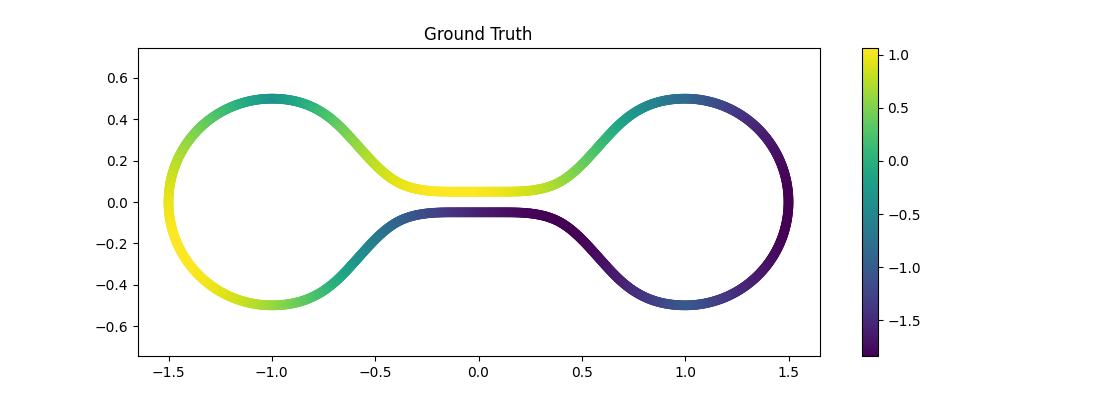

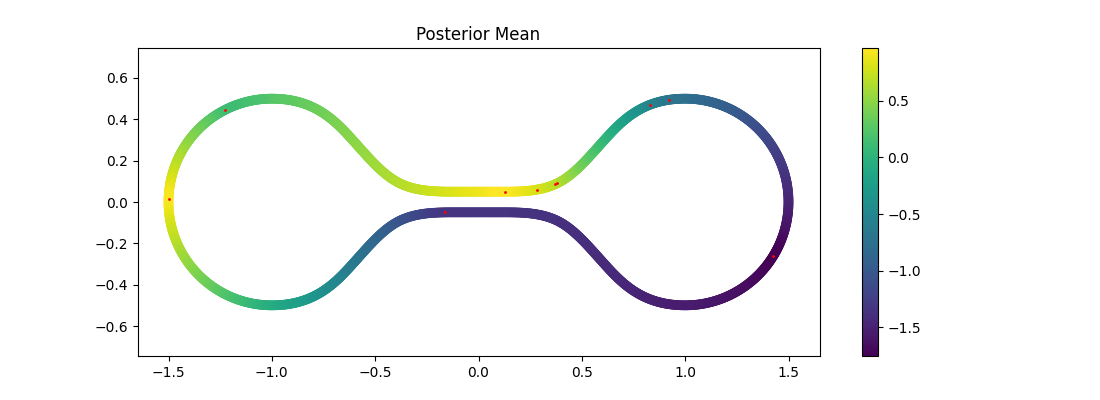

In [15]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=sampled_y.numpy())  # vmin=-0.5, vmax=0.5
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Ground Truth')
    
    posterior_mean_manifold = preds_manifold.mean.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=1.0)
#     ax.scatter(test_x.cpu().numpy()[:, 0], test_x.cpu().numpy()[:, 1], c='k', s=1.0)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')


### Kernel Evaluation

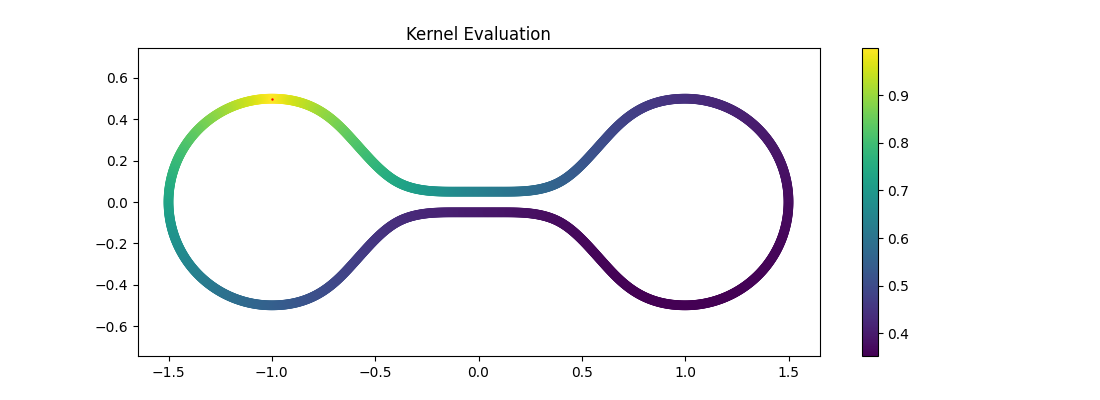

In [16]:
with torch.no_grad():
    k_base = kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x[0, :].unsqueeze(0)).evaluate()
    kernel_eval_manifold = (kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x).evaluate()/k_base).squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=kernel_eval_manifold)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Features

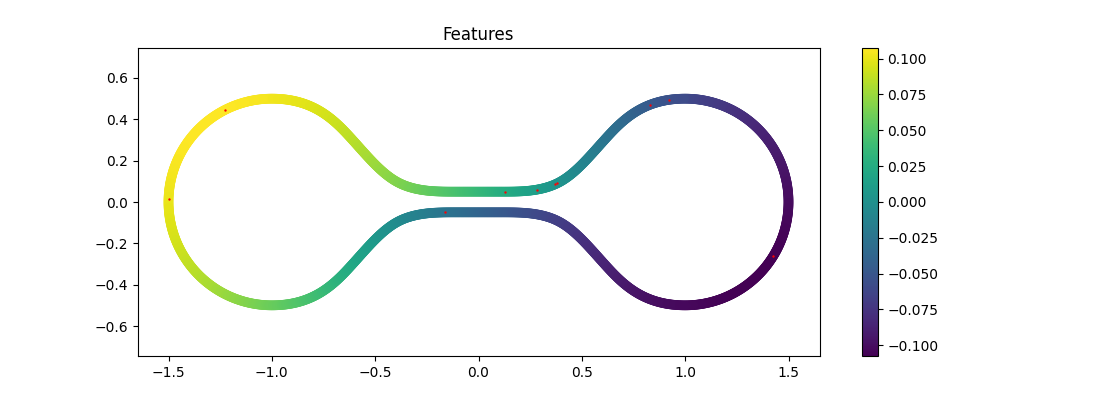

In [17]:
with torch.no_grad():
    c = 3.0
    l_features = kernel.base_kernel.features(noisy_x, c=c)[:,2].cpu().numpy()
    e_features = kernel.base_kernel.eigenvectors[:,2].cpu().numpy()
    f_features = kernel.base_kernel.base_feature._featurize(noisy_x)[:,2].cpu().numpy()
    tmp = kernel.base_kernel.laplace_features(noisy_x)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=e_features)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Features')

### Prior Standard Deviation

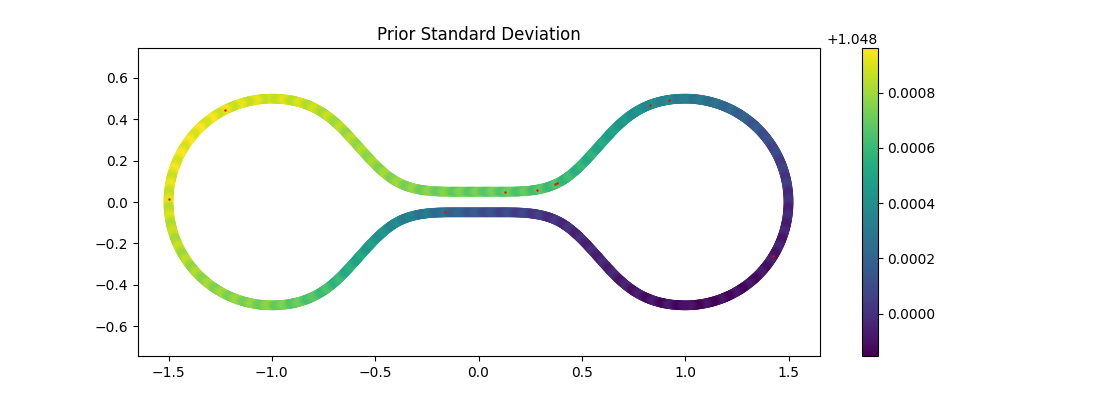

In [18]:
with torch.no_grad():
    prior_std_manifold = model.covar_module(noisy_x, noisy_x, diag=True).sqrt().cpu().numpy()
#     prior_std_manifold = kernel.base_kernel(noisy_x, noisy_x, diag=True).sqrt().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=prior_std_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Standard Deviation')

### Posterior Standard Deviation

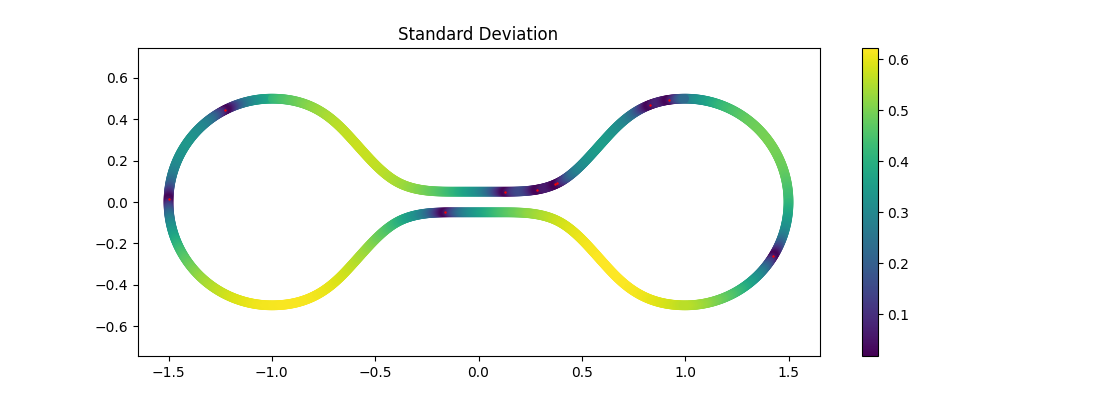

In [19]:
with torch.no_grad():
    posterior_std_manifold = preds_manifold.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_std_manifold)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

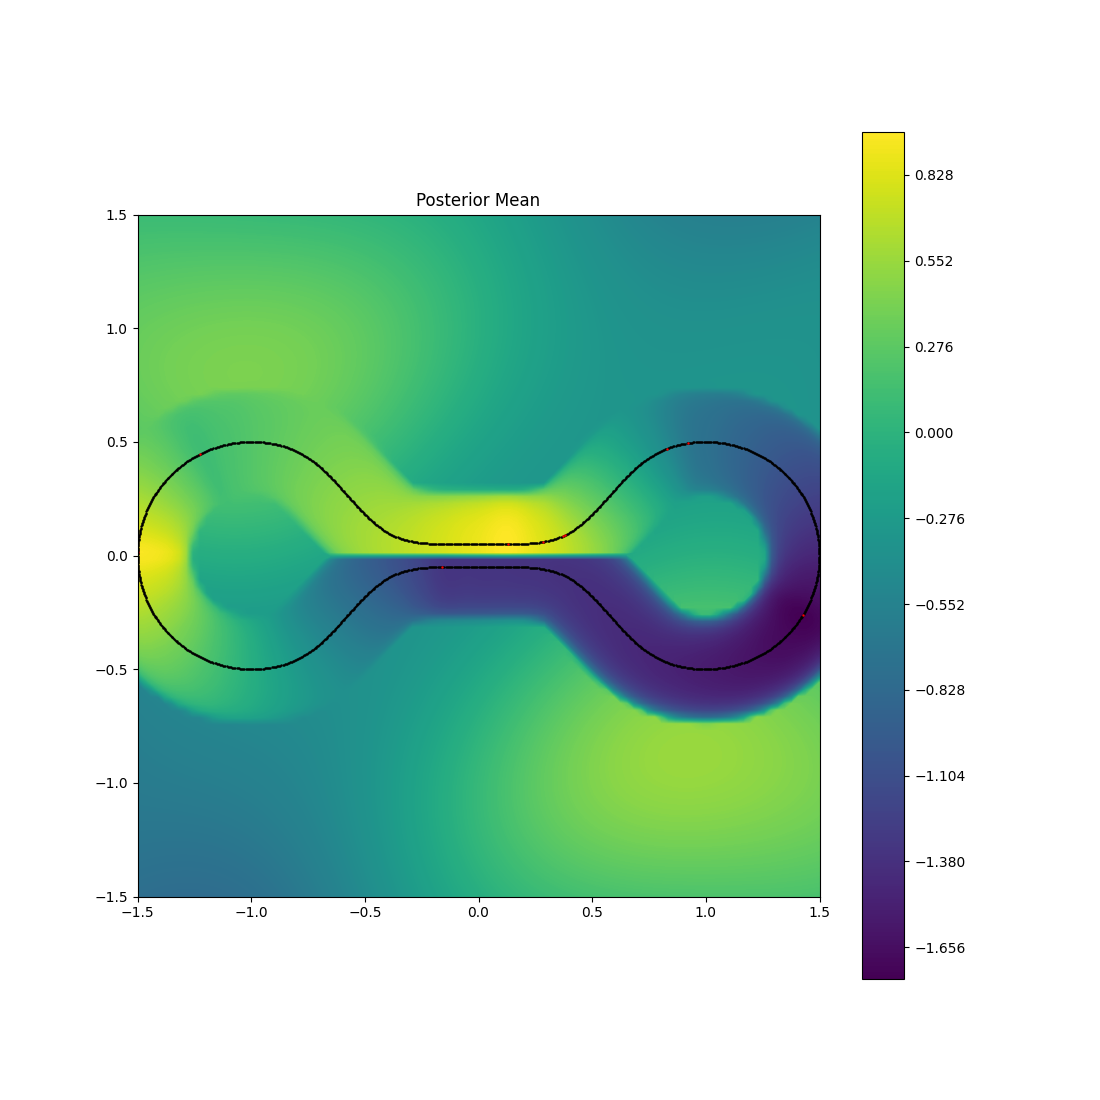

In [20]:
with torch.no_grad():
    posterior_mean_ambient = preds_ambient.mean.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_mean_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

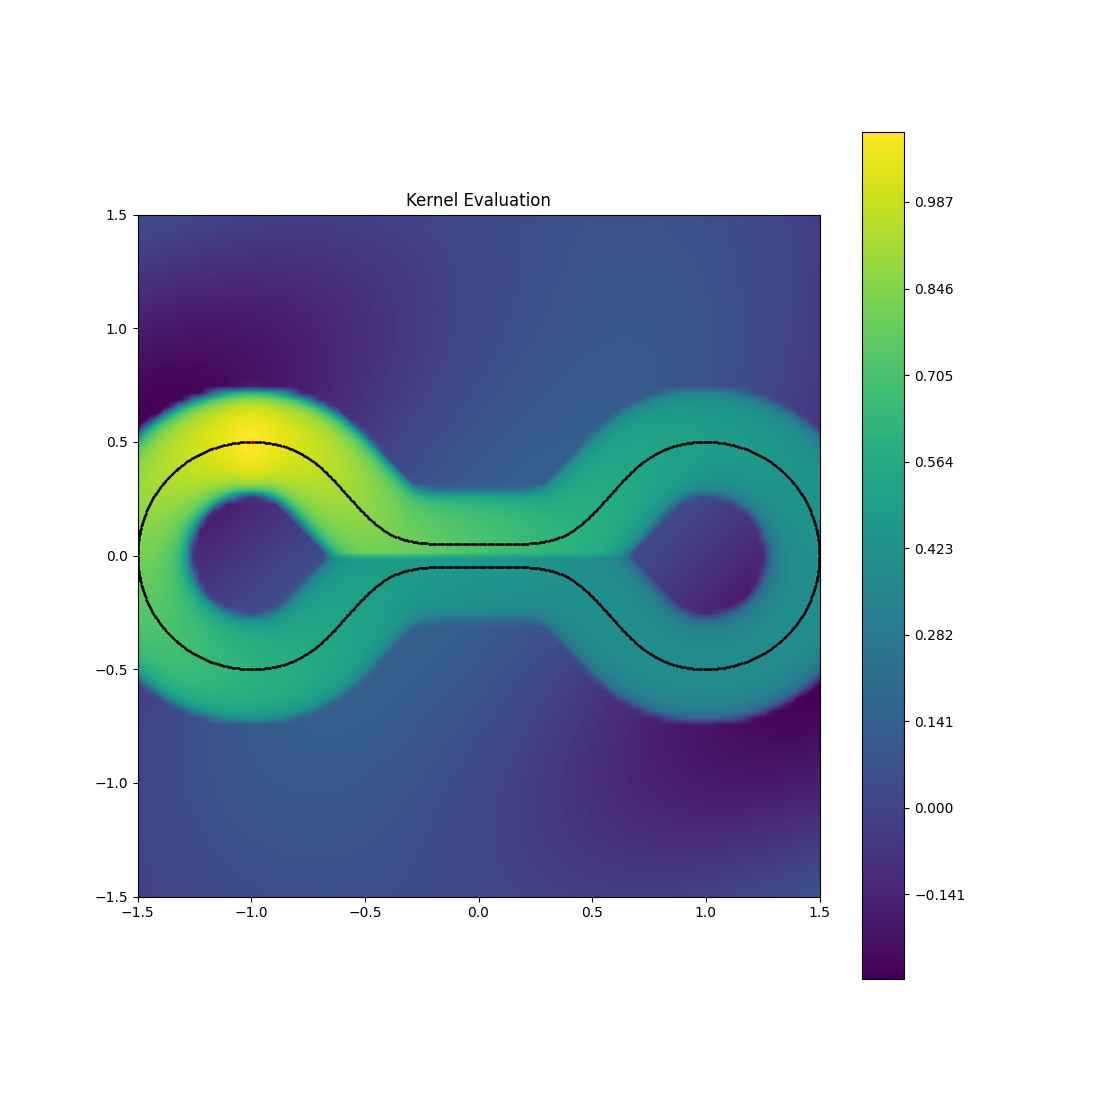

In [21]:
with torch.no_grad():
    kernel_eval_ambient = model.covar_module(noisy_x[0, :].unsqueeze(0), grid_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), kernel_eval_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=1.0)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Kernel Evaluation')

### Ambient Features

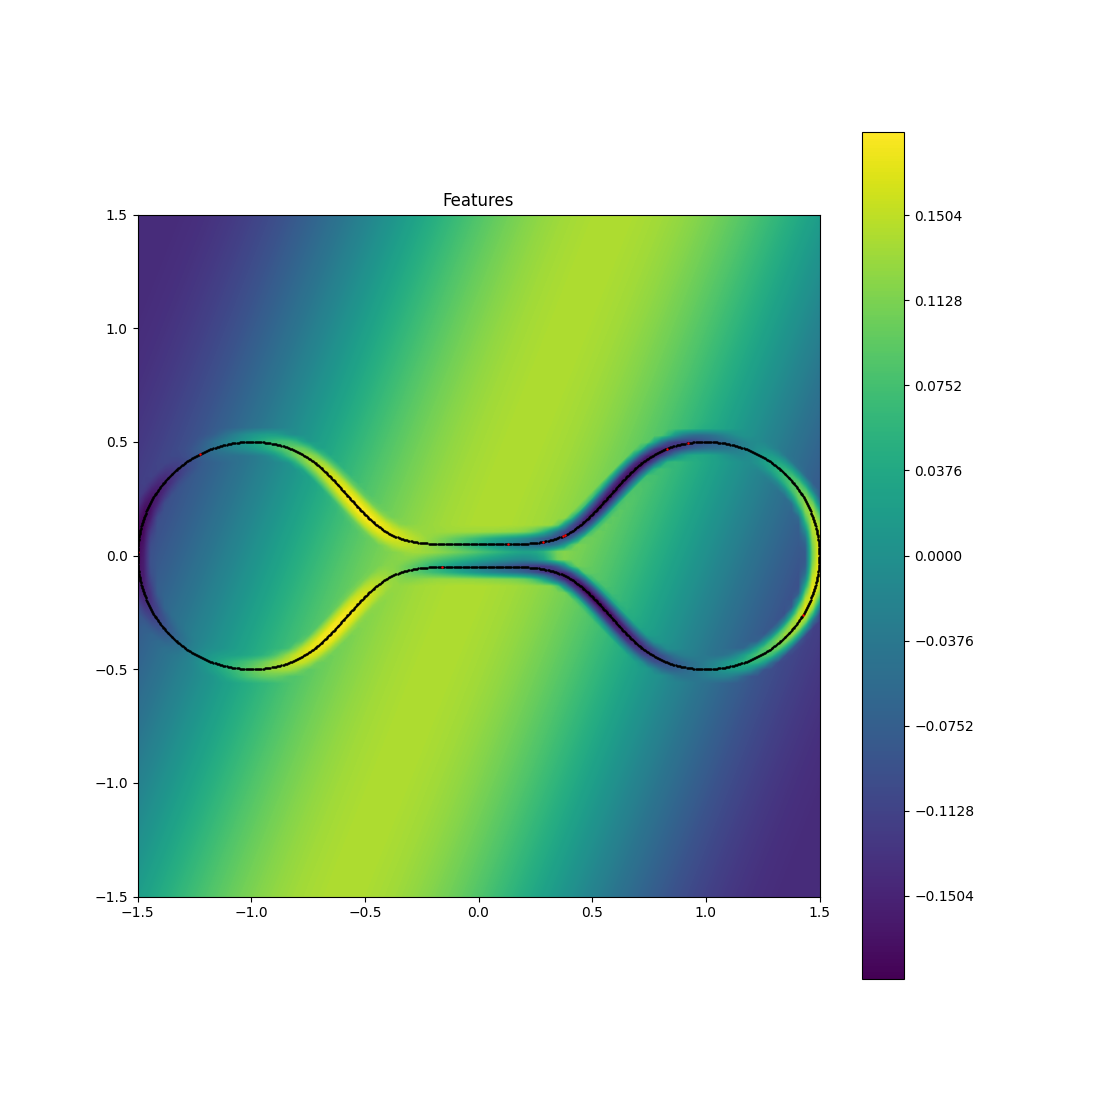

In [22]:
with torch.no_grad():
    laplace_features_ambient = kernel.base_kernel.features(grid_x,  normalize=True, c=3.0)[:,5].cpu().numpy()
    fourier_features_ambient = kernel.base_kernel.base_feature._featurize(grid_x,normalize=True)[:,5].cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), laplace_features_ambient.reshape(resolution, -1), 500)
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
#     ax.add_patch(circle)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Features')

### Ambient Prior Standard Deviation

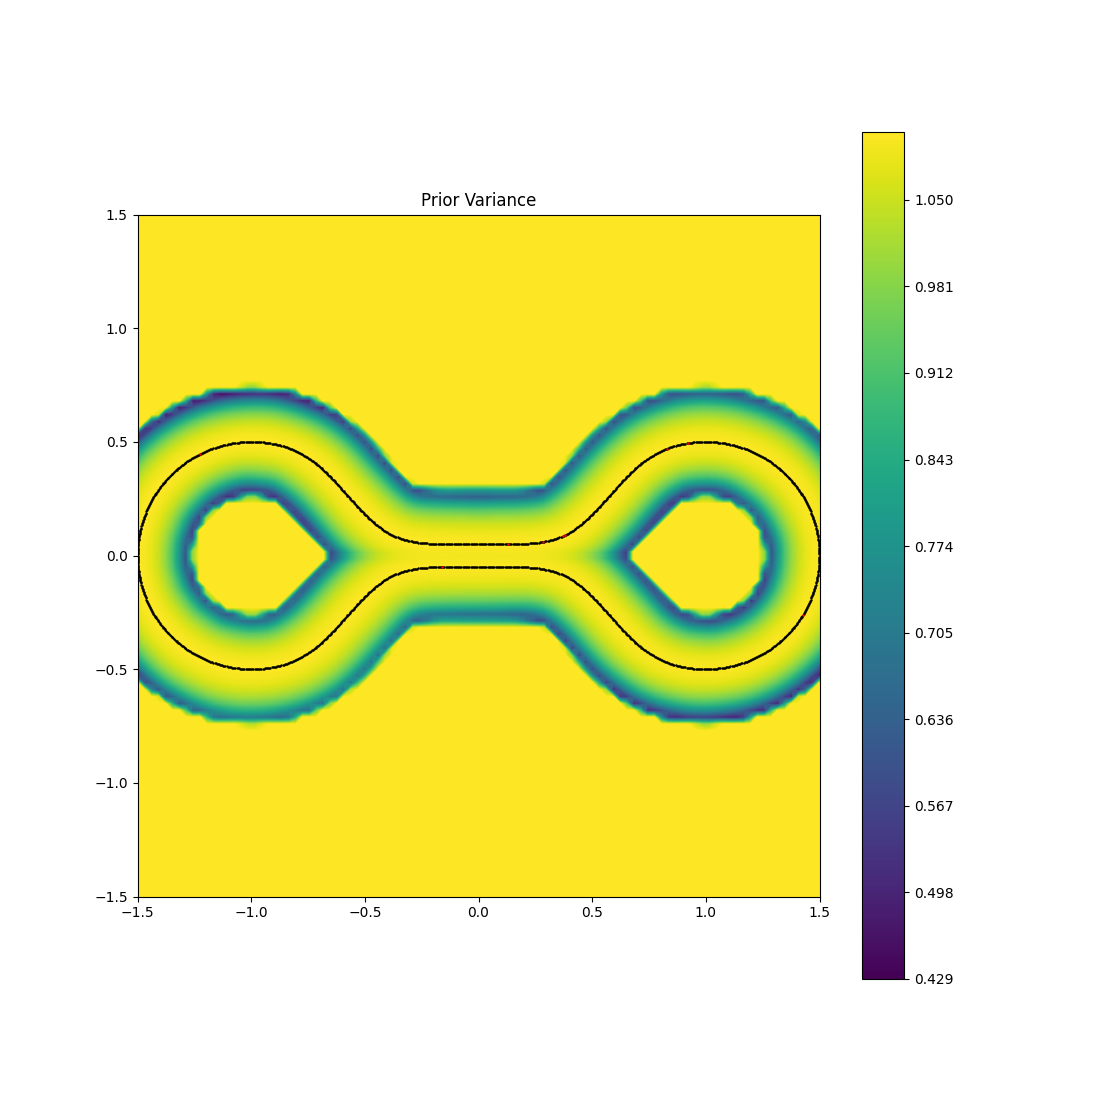

In [23]:
with torch.no_grad():
    prior_std_ambient = model.covar_module(grid_x, grid_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_std_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

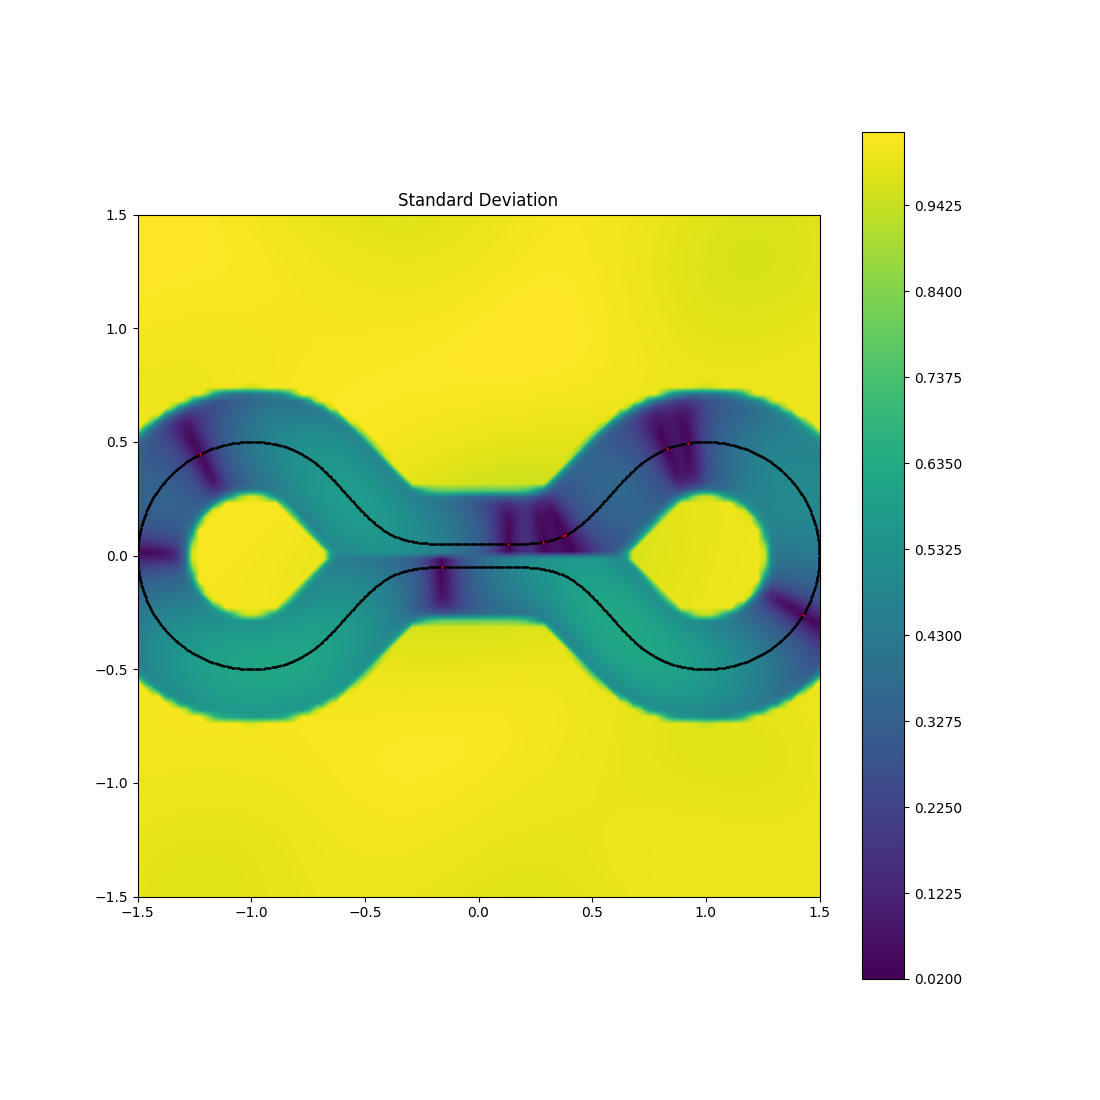

In [24]:
with torch.no_grad():
    posterior_std_ambient = preds_ambient.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c='r', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Standard Deviation')